In [1]:
pip install --upgrade notebook

Note: you may need to restart the kernel to use updated packages.


Loading data...
Data loaded successfully. Shape: (99999, 16)

Target variable created. Distribution:
status
1    0.98885
0    0.01115
Name: proportion, dtype: float64

Generating visualizations...


<Figure size 1500x1000 with 0 Axes>

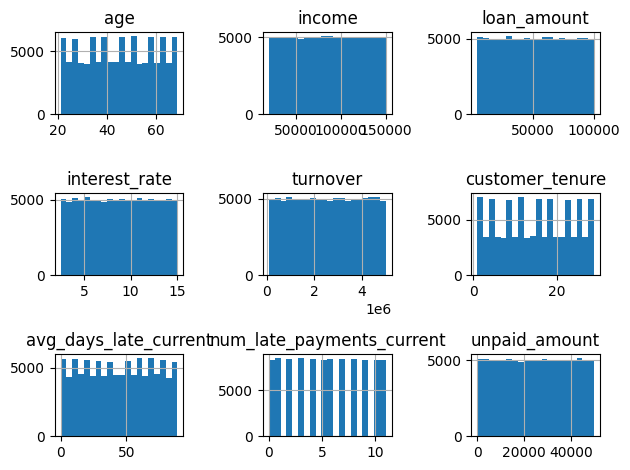

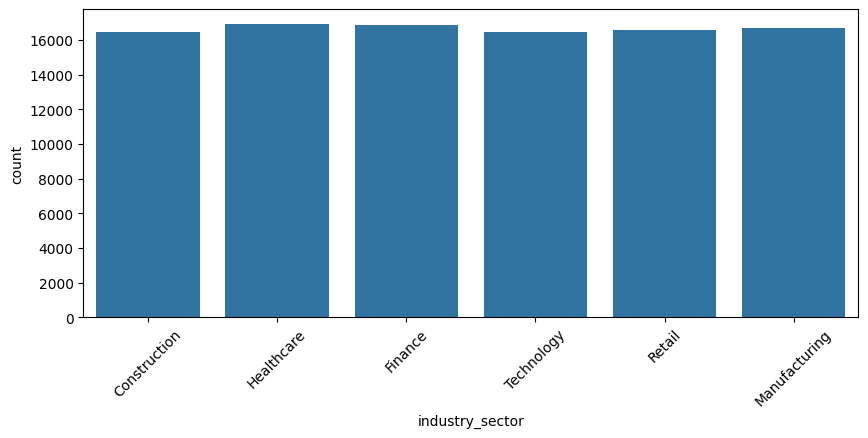

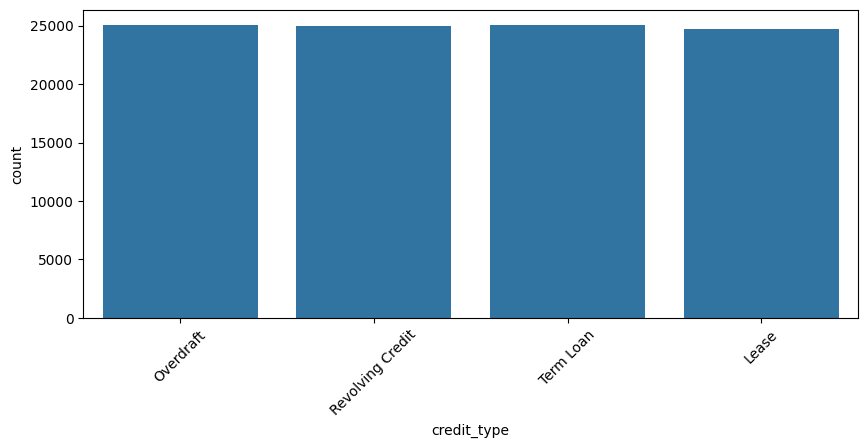

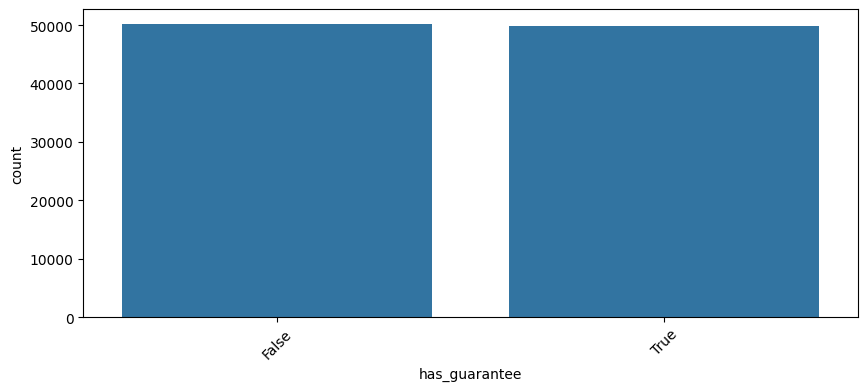

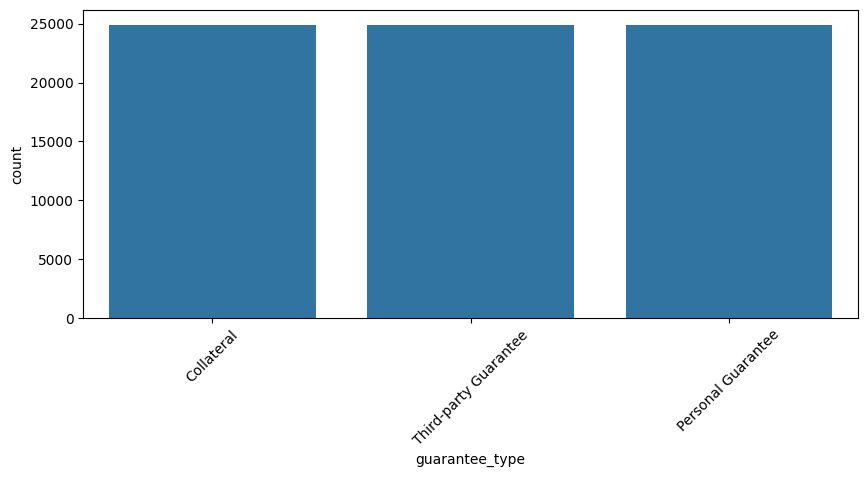

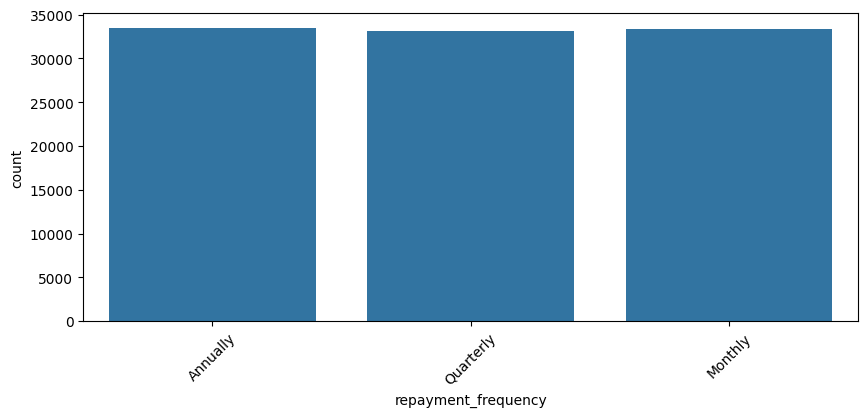


Calculating Mutual Information...


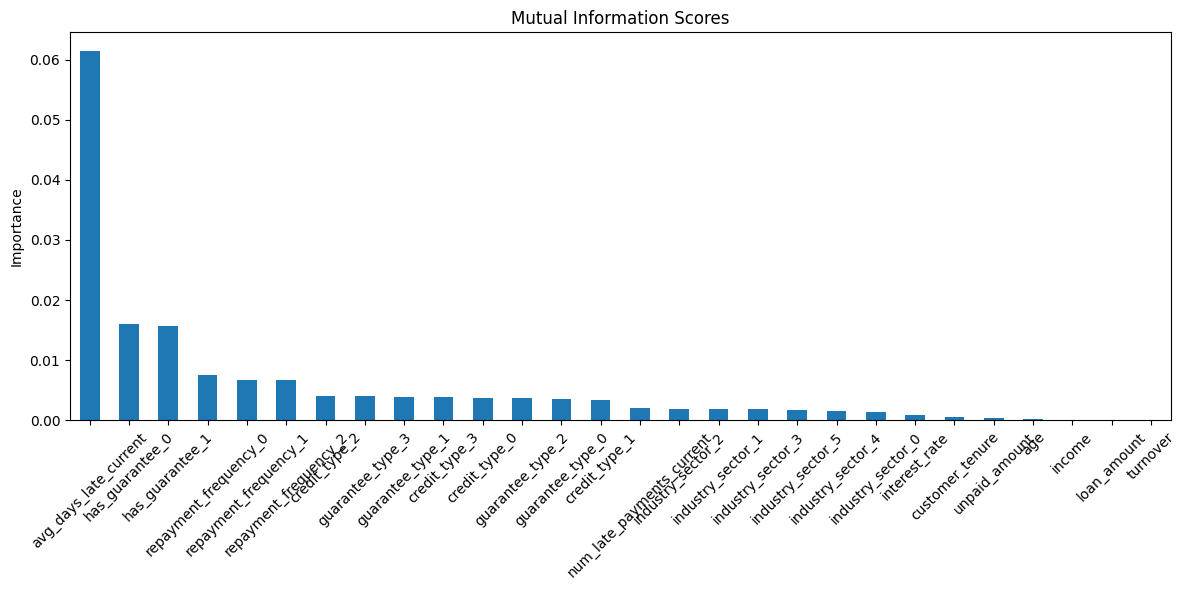

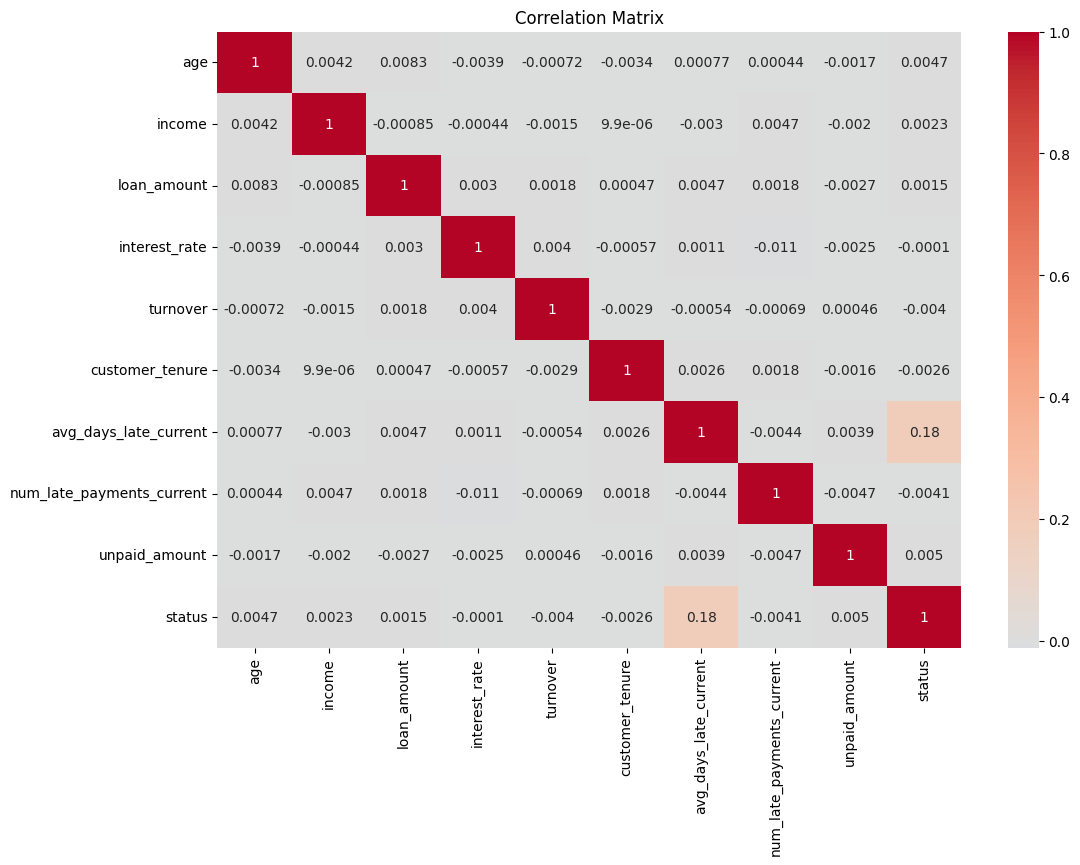


Training Logistic Regression...

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.32      1.00      0.48       223
           1       1.00      0.98      0.99     19777

    accuracy                           0.98     20000
   macro avg       0.66      0.99      0.73     20000
weighted avg       0.99      0.98      0.98     20000


Training Decision Tree...

Decision Tree Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       1.00      1.00      1.00     19777

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


Tuning Decision Tree...

Optimized Decision Tree Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       1.00      1.00      1.00     1977

,Model,AUC
0,Logistic Regression,1.0
1,Decision Tree,1.0
2,Optimized Decision Tree,1.0



Saving models...

Running example application...

Scoring Result:


,error
0,y contains previously unseen labels: 'Unknown'


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import mutual_info_classif
import pickle
import logging
from IPython.display import display

# Configure Jupyter and logging
%matplotlib inline
logging.basicConfig(filename='scoring_errors.log', level=logging.ERROR)
pd.set_option('display.max_columns', None)

# Load the dataset
print("Loading data...")
try:
    df = pd.read_csv('credit_dataset_200000_rows.csv')
    print(f"Data loaded successfully. Shape: {df.shape}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

# Create target variable
df['status'] = (df['avg_days_late_current'] > 0).astype(int)
print("\nTarget variable created. Distribution:")
print(df['status'].value_counts(normalize=True))

# Define feature columns
num_cols = ['age', 'income', 'loan_amount', 'interest_rate', 'turnover', 
            'customer_tenure', 'avg_days_late_current', 'num_late_payments_current', 
            'unpaid_amount']
cat_cols = ['industry_sector', 'credit_type', 'has_guarantee', 'guarantee_type', 
            'repayment_frequency']

# Visualizations
print("\nGenerating visualizations...")
plt.figure(figsize=(15, 10))
df[num_cols].hist(bins=20)
plt.tight_layout()
plt.show()

for col in cat_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col)
    plt.xticks(rotation=45)
    plt.show()

# Prepare data
X = df.drop(['status', 'application_date'], axis=1)
y = df['status']

# Label encode categorical variables
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Mutual Information Calculation with proper feature names
print("\nCalculating Mutual Information...")
preprocessor_for_mi = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

X_mi = preprocessor_for_mi.fit_transform(X)
feature_names = preprocessor_for_mi.get_feature_names_out()

mi_scores = mutual_info_classif(X_mi, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
mi_scores.plot(kind='bar')
plt.title("Mutual Information Scores")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df[num_cols + ['status']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

# Model Pipeline
numeric_features = num_cols
categorical_features = cat_cols

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression
print("\nTraining Logistic Regression...")
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])
lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))

# Decision Tree
print("\nTraining Decision Tree...")
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
dt_pipeline.fit(X_train, y_train)

y_pred_dt = dt_pipeline.predict(X_test)
y_proba_dt = dt_pipeline.predict_proba(X_test)[:, 1]

print("\nDecision Tree Performance:")
print(classification_report(y_test, y_pred_dt))

# Hyperparameter Tuning
print("\nTuning Decision Tree...")
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
y_pred_best_dt = best_dt.predict(X_test)
y_proba_best_dt = best_dt.predict_proba(X_test)[:, 1]

print("\nOptimized Decision Tree Performance:")
print(classification_report(y_test, y_pred_best_dt))
print("Best parameters:", grid_search.best_params_)

# Model Comparison
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Optimized Decision Tree'],
    'AUC': [
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_dt),
        roc_auc_score(y_test, y_proba_best_dt)
    ]
})
print("\nModel Comparison:")
display(results)

# Save models
print("\nSaving models...")
with open('credit_scoring_model.pkl', 'wb') as f:
    pickle.dump(lr_pipeline, f)

model_columns = {
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'label_encoders': label_encoders
}
with open('model_columns.pkl', 'wb') as f:
    pickle.dump(model_columns, f)

# Scoring Functions
RISK_LEVELS = [
    (800, "Very Low", "Approve with best terms and lowest rates"),
    (700, "Low", "Approve with favorable terms"),
    (600, "Medium", "Approve with standard terms"),
    (500, "High", "Approve with higher interest rate or shorter term"),
    (300, "Very High", "Decline or require substantial collateral")
]

def calculate_credit_score(prob_default, app_data=None, threshold=0.5):
    """Calculate credit score with dynamic risk adjustments."""
    if prob_default > 0.7:
        base_score = 300 + int((1 - prob_default) * 200)  # 300-500
    elif prob_default > 0.5:
        base_score = 500 + int((0.7 - prob_default) * 300)  # 500-650
    elif prob_default > threshold:
        base_score = 650 + int((0.5 - prob_default) * 300)  # 650-800
    else:
        base_score = 800 + int((0.3 - prob_default) * 200)  # 800-850
    
    return min(max(base_score, 300), 850)

def preprocess_new_application(data_dict, label_encoders, categorical_cols):
    """Preprocess raw application data for model prediction."""
    if "client_name" in data_dict:
        data_dict = {k: v for k, v in data_dict.items() if k != "client_name"}
        
    expected_columns = [
        'age', 'income', 'loan_amount', 'interest_rate', 'customer_tenure',
        'avg_days_late_current', 'industry_sector', 'credit_type',
        'has_guarantee', 'guarantee_type', 'repayment_frequency', 'turnover'
    ]
    
    df_new = pd.DataFrame(columns=expected_columns)
    
    for col in expected_columns:
        df_new[col] = [data_dict.get(col, 0)]
    
    for col in categorical_cols:
        val = str(df_new[col].iloc[0])
        if val not in label_encoders[col].classes_:
            val = "Unknown"
        try:
            df_new[col] = label_encoders[col].transform([val])[0]
        except ValueError:
            df_new[col] = label_encoders[col].transform(["Unknown"])[0]

    return df_new.drop(columns=["unpaid_amount", "num_late_payments_current"], errors="ignore")

def score_credit_application(app_data, model, label_encoders, categorical_cols, risk_levels=RISK_LEVELS):
    """Generate a complete credit assessment."""
    try:
        X_new = preprocess_new_application(app_data, label_encoders, categorical_cols)
        prob_default = model.predict_proba(X_new)[0][1]
        score = calculate_credit_score(prob_default, app_data)
        
        return {
            "client_name": app_data.get("client_name", "Client"),
            "credit_score": score,
            "default_probability": float(prob_default),
            "recommendation": "Approve" if prob_default < 0.5 else "Review"
        }
        
    except Exception as e:
        logging.error(f"Error processing application: {e}")
        return {"error": str(e)}

# Example Usage
if __name__ == "__main__":
    print("\nRunning example application...")
    try:
        with open('credit_scoring_model.pkl', 'rb') as f:
            model = pickle.load(f)
    except FileNotFoundError:
        print("Error: Model file not found. Train the model first.")
        exit()
    
    new_application = {
        "client_name": "Eric Davis",
        "age": 42,
        "income": 75000,
        "loan_amount": 25000,
        "interest_rate": 8.5,
        "customer_tenure": 5,
        "avg_days_late_current": 2,
        "industry_sector": "Technology",
        "credit_type": "Business Line of Credit",
        "has_guarantee": True,
        "guarantee_type": "Property",
        "repayment_frequency": "Monthly",
        "turnover": 1000000,
    }
    
    scoring_result = score_credit_application(
        new_application,
        model,
        label_encoders,
        categorical_features
    )
    
    print("\nScoring Result:")
    display(pd.DataFrame([scoring_result]))

1. Loading and preparing data...
Data loaded successfully. Shape: (99999, 16)

Target variable distribution:
status
1    0.98779
0    0.01221
Name: proportion, dtype: float64

2. Generating visualizations...


<Figure size 1500x1000 with 0 Axes>

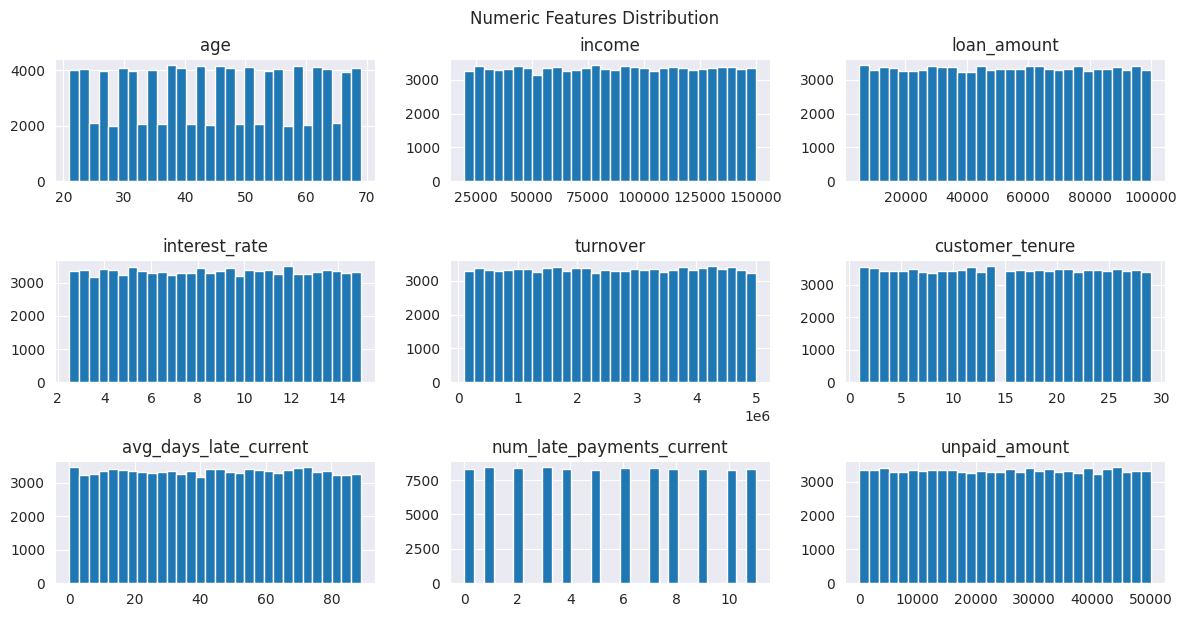

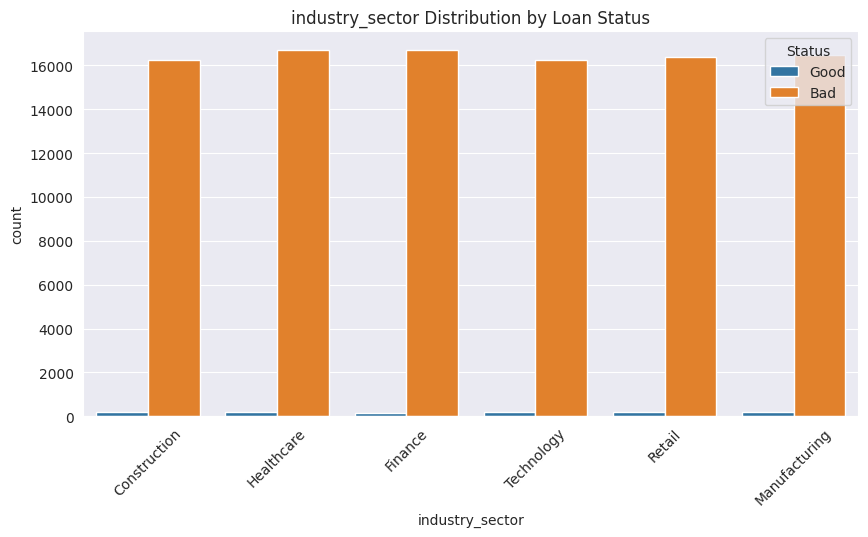

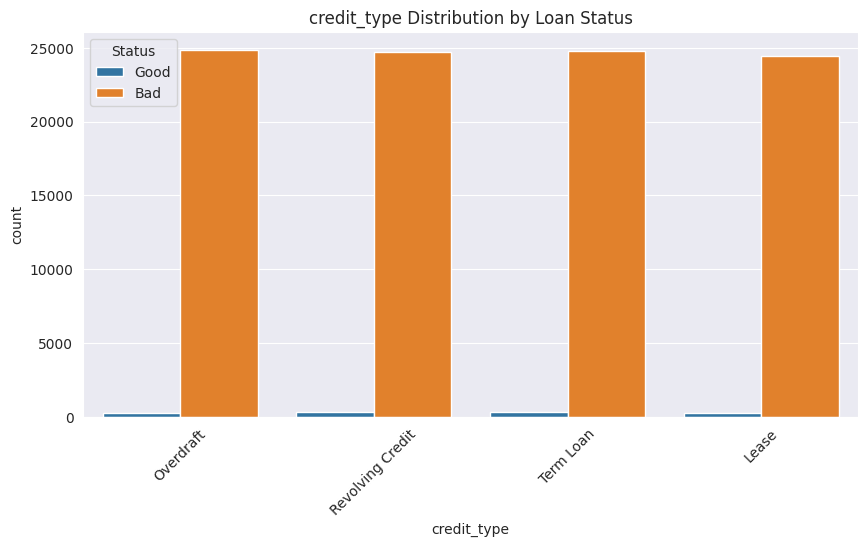

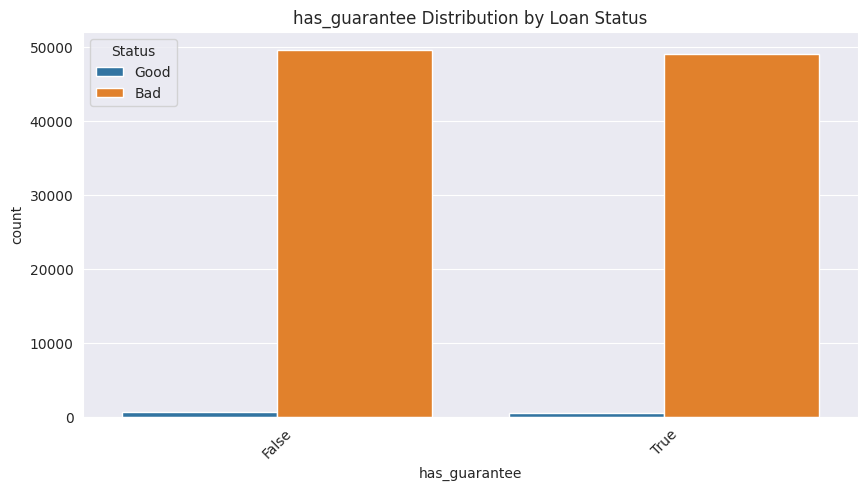

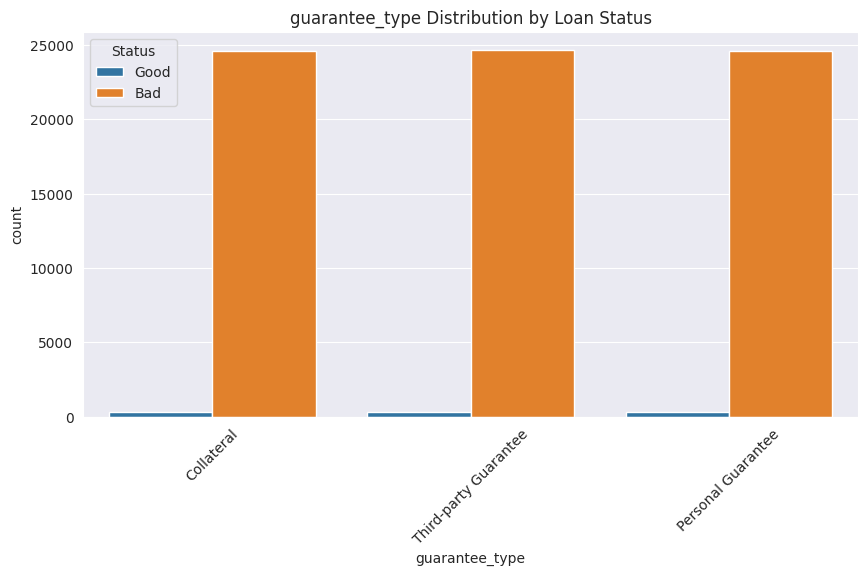

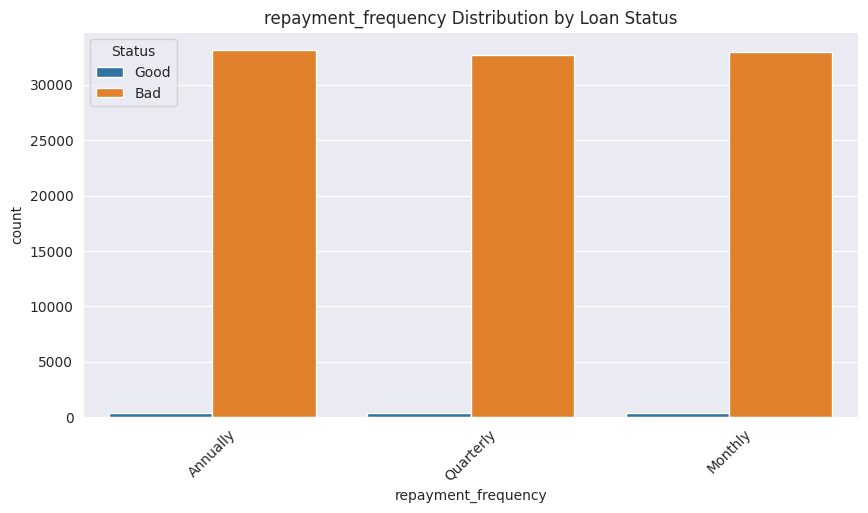

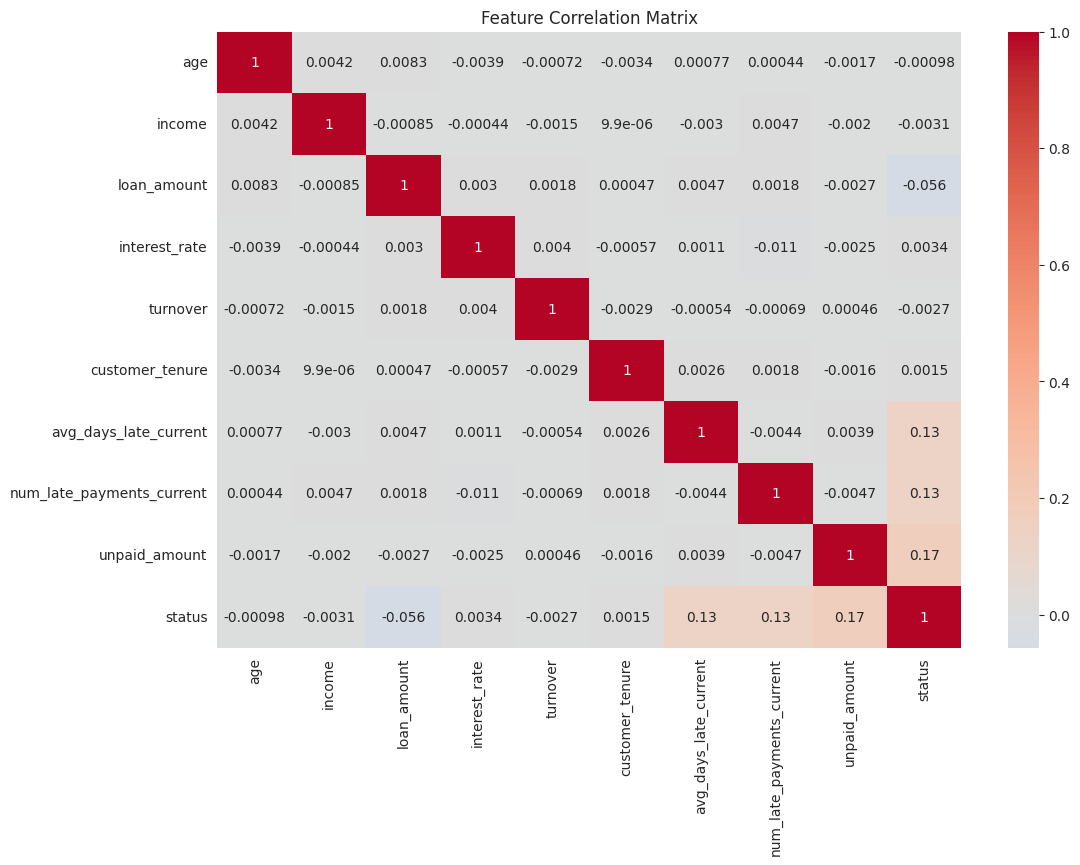


3. Calculating feature importance...


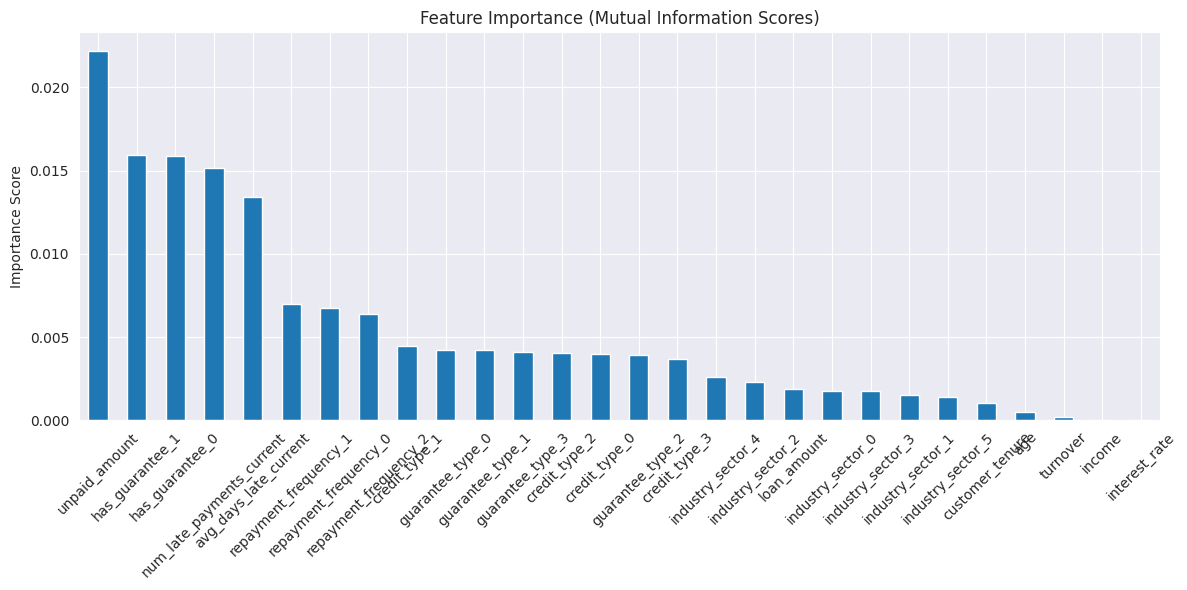


4. Building models with class balancing...

Training Logistic Regression with SMOTE...

Logistic Regression Performance:
              precision    recall  f1-score   support

        Good       0.34      0.99      0.51       244
         Bad       1.00      0.98      0.99     19756

    accuracy                           0.98     20000
   macro avg       0.67      0.98      0.75     20000
weighted avg       0.99      0.98      0.98     20000



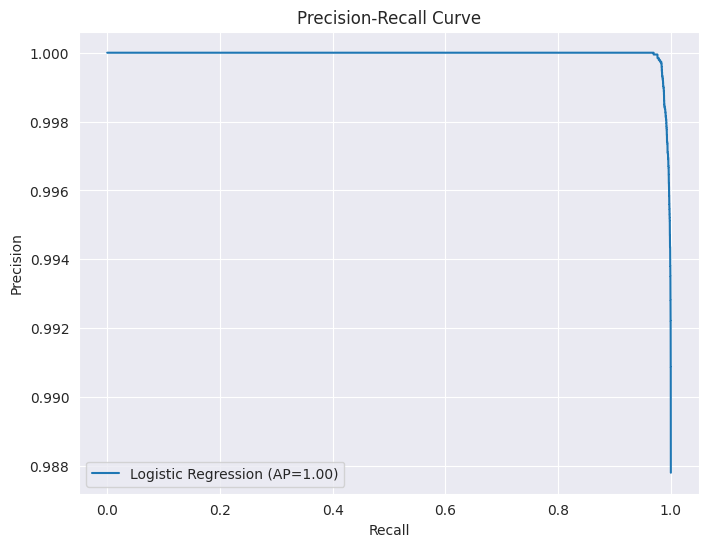


Training Decision Tree...

Decision Tree Performance:
              precision    recall  f1-score   support

        Good       0.98      0.97      0.97       244
         Bad       1.00      1.00      1.00     19756

    accuracy                           1.00     20000
   macro avg       0.99      0.98      0.99     20000
weighted avg       1.00      1.00      1.00     20000


Tuning Decision Tree with Cross-Validation...

Optimized Decision Tree Performance:
              precision    recall  f1-score   support

        Good       0.68      1.00      0.81       244
         Bad       1.00      0.99      1.00     19756

    accuracy                           0.99     20000
   macro avg       0.84      1.00      0.90     20000
weighted avg       1.00      0.99      0.99     20000

Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_split': 2}

Model Comparison:


,Model,AUC,Average Precision
0,Logistic Regression,0.996405,0.999956
1,Decision Tree,0.983480,0.999592
2,Optimized Decision Tree,0.996944,0.999929



Saving models...

Running example application...

Scoring Result:


,client_name,credit_score,risk_level,default_probability,recommendation,decision
0,John Smith,850,Very Low,3.202756e-07,Approve with best terms,Approve


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import pickle
import logging
from IPython.display import display

# Configure Jupyter and logging
%matplotlib inline
logging.basicConfig(filename='scoring_errors.log', level=logging.INFO)
pd.set_option('display.max_columns', None)
sns.set_style("darkgrid")  # Updated styling
plt.rcParams['figure.figsize'] = (12, 6)

# Load the dataset
print("1. Loading and preparing data...")
try:
    df = pd.read_csv('credit_dataset_200000_rows.csv')
    print(f"Data loaded successfully. Shape: {df.shape}")
    
    # More nuanced target variable definition
    df['status'] = np.where(
        (df['avg_days_late_current'] > 30) | 
        (df['num_late_payments_current'] > 3) |
        (df['unpaid_amount'] > 0.1 * df['loan_amount']),
        1,  # Bad loan
        0   # Good loan
    )
    
    print("\nTarget variable distribution:")
    print(df['status'].value_counts(normalize=True))
    
except Exception as e:
    logging.error(f"Error loading data: {e}")
    raise

# Define feature columns
num_cols = ['age', 'income', 'loan_amount', 'interest_rate', 'turnover', 
            'customer_tenure', 'avg_days_late_current', 'num_late_payments_current', 
            'unpaid_amount']
cat_cols = ['industry_sector', 'credit_type', 'has_guarantee', 'guarantee_type', 
            'repayment_frequency']

# Enhanced Visualization
print("\n2. Generating visualizations...")
def plot_distributions():
    # Numeric features
    plt.figure(figsize=(15, 10))
    df[num_cols].hist(bins=30, layout=(3, 3))
    plt.tight_layout()
    plt.suptitle("Numeric Features Distribution", y=1.02)
    plt.show()
    
    # Categorical features
    for col in cat_cols:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df, x=col, hue='status')
        plt.title(f"{col} Distribution by Loan Status")
        plt.xticks(rotation=45)
        plt.legend(title='Status', labels=['Good', 'Bad'])
        plt.show()
        
    # Correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[num_cols + ['status']].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title("Feature Correlation Matrix")
    plt.show()

plot_distributions()

# Prepare data
X = df.drop(['status', 'application_date'], axis=1)
y = df['status']

# Enhanced Label Encoding with unknown category handling
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    # Add dummy suffix and unknown category
    X[col] = X[col].astype(str) + '_'
    le.fit(X[col])
    le.classes_ = np.append(le.classes_, "<UNK>")  # Add unknown category
    label_encoders[col] = le
    X[col] = le.transform(X[col])

# Mutual Information Calculation
print("\n3. Calculating feature importance...")
preprocessor_for_mi = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

X_mi = preprocessor_for_mi.fit_transform(X)
feature_names = preprocessor_for_mi.get_feature_names_out()

mi_scores = mutual_info_classif(X_mi, y, random_state=42)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
mi_scores.plot(kind='bar')
plt.title("Feature Importance (Mutual Information Scores)")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Model Pipeline with Class Balancing
print("\n4. Building models with class balancing...")
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression with SMOTE
print("\nTraining Logistic Regression with SMOTE...")
lr_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred_lr, target_names=['Good', 'Bad']))

# Plot PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_lr)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Logistic Regression (AP={average_precision_score(y_test, y_proba_lr):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Decision Tree with Class Weighting
print("\nTraining Decision Tree...")
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_pipeline.predict(X_test)
y_proba_dt = dt_pipeline.predict_proba(X_test)[:, 1]

print("\nDecision Tree Performance:")
print(classification_report(y_test, y_pred_dt, target_names=['Good', 'Bad']))

# Hyperparameter Tuning with Cross-Validation
print("\nTuning Decision Tree with Cross-Validation...")
param_grid = {
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    dt_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='average_precision',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
y_pred_best_dt = best_dt.predict(X_test)
y_proba_best_dt = best_dt.predict_proba(X_test)[:, 1]

print("\nOptimized Decision Tree Performance:")
print(classification_report(y_test, y_pred_best_dt, target_names=['Good', 'Bad']))
print("Best parameters:", grid_search.best_params_)

# Model Comparison
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Optimized Decision Tree'],
    'AUC': [
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_dt),
        roc_auc_score(y_test, y_proba_best_dt)
    ],
    'Average Precision': [
        average_precision_score(y_test, y_proba_lr),
        average_precision_score(y_test, y_proba_dt),
        average_precision_score(y_test, y_proba_best_dt)
    ]
})
print("\nModel Comparison:")
display(results)

# Save models and artifacts
print("\nSaving models...")
model_artifacts = {
    'model': lr_pipeline,
    'label_encoders': label_encoders,
    'num_cols': num_cols,
    'cat_cols': cat_cols,
    'preprocessor': preprocessor
}

with open('credit_scoring_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

# Enhanced Scoring Function
RISK_LEVELS = [
    (800, "Very Low", "Approve with best terms"),
    (700, "Low", "Approve with favorable terms"),
    (600, "Medium", "Approve with standard terms"),
    (500, "High", "Approve with higher interest rate"),
    (300, "Very High", "Decline or require collateral")
]

def calculate_credit_score(prob_default):
    """Dynamic score calculation with risk bands"""
    risk_bands = [
        (0.8, 300, 500),   # Very High risk
        (0.6, 500, 650),   # High risk
        (0.4, 650, 750),   # Medium risk
        (0.2, 750, 850),   # Low risk
        (0.0, 850, 900)    # Very Low risk
    ]
    
    for upper, lower, upper_score in risk_bands:
        if prob_default > upper:
            return min(lower + int((upper - prob_default) * (upper_score - lower) / (upper - lower)), 850)
    return 900  # Perfect score

def preprocess_new_application(data_dict, label_encoders, num_cols, cat_cols):
    """Robust preprocessing with unknown category handling"""
    processed = {}
    
    for col in num_cols:
        processed[col] = [float(data_dict.get(col, 0))]
        
    for col in cat_cols:
        val = str(data_dict.get(col, "")) + '_'  # Match training format
        le = label_encoders[col]
        processed[col] = [le.transform([val])[0] if val in le.classes_ else le.transform(["<UNK>"])[0]]
    
    return pd.DataFrame(processed)

def score_credit_application(app_data, model_artifacts, risk_levels=RISK_LEVELS):
    """Complete credit assessment with error handling"""
    try:
        # Preprocess
        X_new = preprocess_new_application(
            app_data,
            model_artifacts['label_encoders'],
            model_artifacts['num_cols'],
            model_artifacts['cat_cols']
        )
        
        # Predict
        prob_default = model_artifacts['model'].predict_proba(X_new)[0][1]
        score = calculate_credit_score(prob_default)
        
        # Determine risk level
        risk_level = next((rl for rl in risk_levels if score >= rl[0]), risk_levels[-1])
        
        return {
            "client_name": app_data.get("client_name", "Applicant"),
            "credit_score": score,
            "risk_level": risk_level[1],
            "default_probability": float(prob_default),
            "recommendation": risk_level[2],
            "decision": "Approve" if score >= 500 else "Review"
        }
        
    except Exception as e:
        logging.error(f"Scoring error: {e}", exc_info=True)
        return {
            "error": str(e),
            "client_name": app_data.get("client_name", "Applicant")
        }

# Example Usage
if __name__ == "__main__":
    print("\nRunning example application...")
    try:
        with open('credit_scoring_model.pkl', 'rb') as f:
            model_artifacts = pickle.load(f)
    except FileNotFoundError:
        print("Error: Model file not found")
        exit()
    
    new_application = {
        "client_name": "John Smith",
        "age": 35,
        "income": 85000,
        "loan_amount": 20000,
        "interest_rate": 7.5,
        "customer_tenure": 3,
        "avg_days_late_current": 5,
        "industry_sector": "Technology",
        "credit_type": "Personal Loan",
        "has_guarantee": False,
        "guarantee_type": "None",
        "repayment_frequency": "Monthly",
        "turnover": 500000
    }
    
    result = score_credit_application(new_application, model_artifacts)
    print("\nScoring Result:")
    display(pd.DataFrame([result]))

In [1]:
import os
print(os.path.exists('credit_scoring_model.pkl'))  # Should print True

True


In [2]:
print(os.path.abspath('credit_scoring_model.pkl'))

/home/ebongue/Desktop/EOY/credit/dataset/set3/credit_scoring_model.pkl
